In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

/content/drive/My Drive/automatic-asset-classification
data/


In [5]:
%ls "/content/drive/My Drive/automatic-asset-classification/data"

final_dataset/


In [0]:
from fastai.vision import *
#from fastai.widgets.image_cleaner import *
import matplotlib.pyplot as plt
import os
import pandas as pd


In [0]:
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
data = ImageDataBunch.from_folder(image_path, valid_pct = 0.2, size=224,ds_tfms=get_transforms(), test = "test").normalize(imagenet_stats)


In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
#fit on just end layers (other layers are froze)
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 113MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,2.376389,1.638292,0.458333,01:23
1,1.586587,1.230265,0.291667,00:13
2,1.199021,0.936049,0.239583,00:11
3,0.963603,0.837352,0.218750,00:11


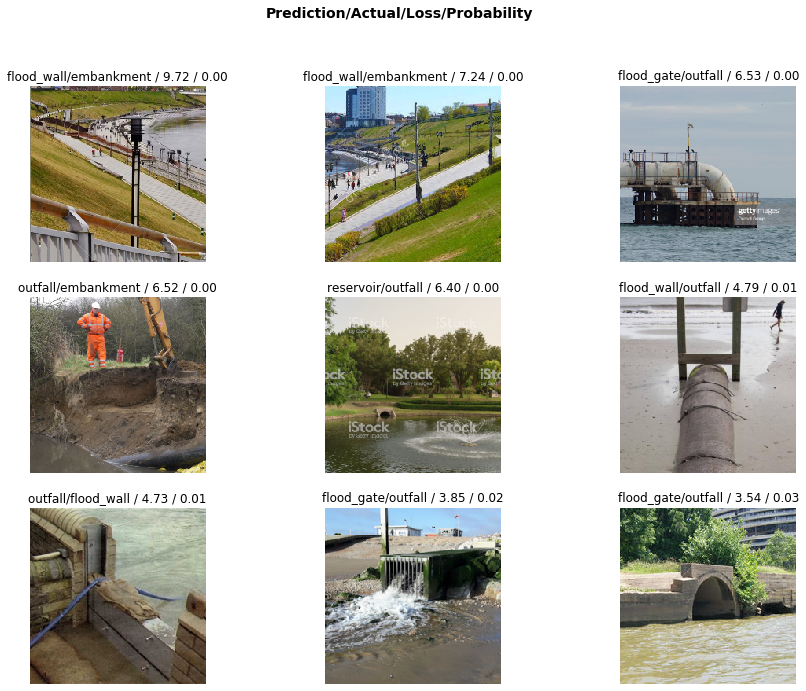

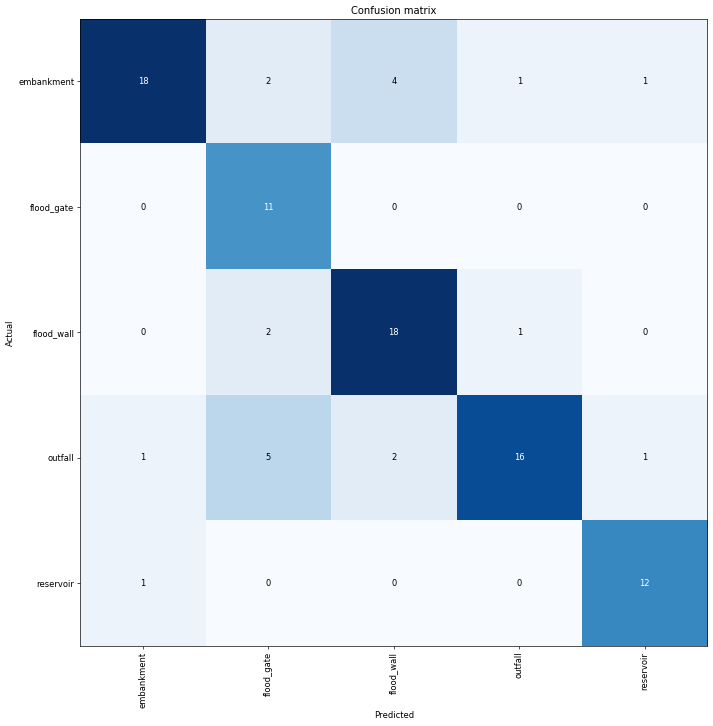

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
#len(data.valid_ds)==len(losses)==len(idxs)
#validation analysis
interp.plot_top_losses(9, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.58E-03


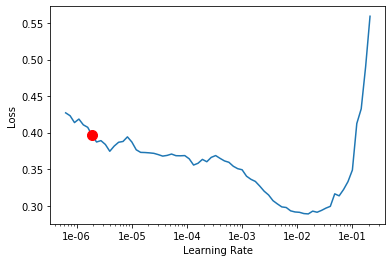

In [11]:
learn.recorder.plot(suggestion=True)

In [14]:
learn_dict = {}
learn.save("intial_start")
for i in range(10):
  learn_ = cnn_learner(data, models.resnet34, metrics=error_rate)
  learn_.load("intial_start")
  learn_.unfreeze()
  learn_.fit_one_cycle(5, max_lr = slice(1E-07, 1E-03))
  learn_dict[i] = learn_
  learn_.save("learner_numer_" + str(i))

epoch,train_loss,valid_loss,error_rate,time
0,0.376908,0.807913,0.218750,00:12
1,0.380499,0.751878,0.208333,00:11
2,0.333976,0.719541,0.218750,00:11
3,0.305403,0.671750,0.218750,00:12
4,0.274048,0.665876,0.229167,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.398871,0.787293,0.208333,00:11
1,0.350789,0.725108,0.187500,00:11
2,0.311850,0.696756,0.197917,00:11
3,0.295343,0.673116,0.166667,00:11
4,0.268455,0.663000,0.166667,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.364379,0.805426,0.218750,00:11
1,0.351641,0.742603,0.229167,00:11
2,0.317173,0.685792,0.187500,00:11
3,0.283907,0.662414,0.177083,00:11
4,0.252738,0.644472,0.156250,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.359900,0.797355,0.218750,00:12
1,0.343312,0.703389,0.187500,00:11
2,0.312534,0.671889,0.208333,00:11
3,0.289030,0.652670,0.187500,00:11
4,0.283586,0.645893,0.197917,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.416445,0.791036,0.197917,00:12
1,0.386803,0.719773,0.197917,00:11
2,0.331474,0.707853,0.218750,00:11
3,0.296268,0.698256,0.218750,00:11
4,0.271194,0.693590,0.218750,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.353751,0.781995,0.218750,00:12
1,0.320541,0.725064,0.177083,00:12
2,0.282335,0.672991,0.166667,00:11
3,0.258916,0.634340,0.166667,00:11
4,0.237345,0.630468,0.166667,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.367913,0.778450,0.218750,00:12
1,0.335276,0.745005,0.197917,00:11
2,0.303520,0.710228,0.218750,00:11
3,0.272659,0.691887,0.218750,00:11
4,0.238623,0.698347,0.229167,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.325742,0.762649,0.197917,00:12
1,0.331134,0.683871,0.187500,00:11
2,0.322705,0.628007,0.166667,00:11
3,0.305661,0.589290,0.156250,00:11
4,0.280983,0.581333,0.145833,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.433183,0.779281,0.208333,00:12
1,0.405444,0.689698,0.166667,00:11
2,0.344576,0.673131,0.177083,00:12
3,0.298395,0.652594,0.177083,00:12
4,0.272189,0.636979,0.177083,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.358024,0.785900,0.197917,00:12
1,0.319926,0.687738,0.177083,00:12
2,0.288699,0.609314,0.156250,00:12
3,0.269885,0.583139,0.156250,00:11
4,0.244778,0.569828,0.156250,00:11


In [38]:
preds,y = learn_.get_preds(ds_type=DatasetType.Valid)

In [27]:
list_of_preds = []
keys = learn_dict.keys()
for key in keys:
  learner = learn_dict[key]
  preds, y = learner.get_preds(ds_type=DatasetType.Valid)
  list_of_preds.append(preds)

In [0]:
full_pred = sum(list_of_preds)
full_pred = full_pred/10

In [0]:
pred_out = np.argmax(full_pred, axis = 1).numpy()

In [0]:
correct = 0
incorrect = 0
y = y.numpy()
for i in range(len(pred_out)):
  if y[i] == pred_out[i]:
    correct += 1
  else:
    incorrect += 1

In [43]:
correct, incorrect, correct/len(y), incorrect/len(y)

(79, 17, 0.8229166666666666, 0.17708333333333334)